# <u> COGS 118B Assignment 2 </u>



### Section 0 : Academic Integrity (1 point)

 What is allowed:

1. Studying material using online resources.
2. Consulting online resources to help with the assignments and providing citations. 
3. Collaborate with classmates (ex: studying for the exam in pairs and fixing each other’s code.)
4. Asking ChatGPT to help you understand concepts. (make sure ChatGPT is speaking the truth) If you are studying for a concept that is in an assignment, make sure to provide citations. (ex. What prompt did you use?)

What is NOT allowed:

1. Copying answers from online resources word by word. If you cannot understand it, do not copy it.

2. Copying answers from your peers.
3. Using answers directly generated by ChatGPT or other AI tools. If you used AI tools to help you answer homework questions, please cite the AI tools you have used. Directly copying and pasting solutions from online tools without proper learning and citations is considered cheating. It would not be smart to cheat using machine learning tools in a machine learning class. We will flag you if we detect any suspicious responses.

If you have read the rules above, respond "I understand I have to provide citations." below.

I understand I have to provide citations. 

#### Part 1 

In this part of the assignment we will be applying PCA and **K-means clustering** on multi-dimensional data points. We will then implement the **EM** algorithm on the same dataset (with the assist of PCA) and we can visualize the performance of the two algorithms. 

##### The dataset:
We are using real student data recorded from Cogs. Sci. students. We have removed sensitive information such as student PID and names. You can look at the column names to see the range and the type of numbers we are handling. Applying a clustering algorithm to the dataset allows us to find hidden student groups. Once we have defined distinct student groups, we can further analyze the data and look into a personalized method of teaching to better assist with students' learning. Hence, clustering is a helpful technique when doing research in pedagogy.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = pd.read_csv('PA2_data.csv')
data.head()


,ID,number of subjects learned,How comfortable are you with programming?,How comfortable are you with statistics?,programming lanuages,total_points,Final Project,hw time sum
0,002_wi20,4,6,5,1,97.95,21.75,14.0
1,005_wi20,1,6,6,0,101.15,23.50,35.0
2,007_wi20,5,10,8,1,97.48,24.50,6.5
3,011_wi20,2,7,3,0,95.72,22.00,37.0
4,014_wi20,2,4,7,0,98.70,23.25,48.0


Before PCA, we have to transform the dataframe into a Numpy matrix. 

In [3]:
X = data.to_numpy()

X = X[:,1:].astype(float)
X = X/X.max(axis=0)           # scaling the values to [0,1] range. We can divided by the max value of each column because we do not have negative values in the data.
print('Shape of X: ', X.shape)

Shape of X:  (181, 7)


**To-do** (1.1): (2 points)

Apply PCA on the dataset `X` using the PCA package from sklearn. Set the number of principle components to 2. No need to normalize the data since it has already been processed for you. 

Plot the transformed data onto a 2-d scatter plot. 

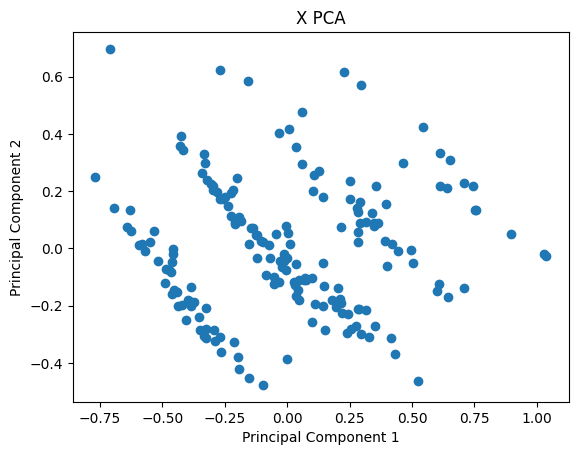

In [15]:
#1.1
X_pca = PCA(n_components = 2)
plt.scatter(X_pca.fit_transform(X)[:,0], X_pca.fit_transform(X)[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('X PCA')
plt.show()


**To-do** (1.2) (2 point) 

Use KM clustering module from SkLearn to perform clustering on the PCA transformed dataset. Set the number of clusters (k) = 4. (Notice that since clusters are not circular blobs, K-mean cannot cluster in an interpretable way.)

Plot the colored clusters. (Like we did in the first assignment)

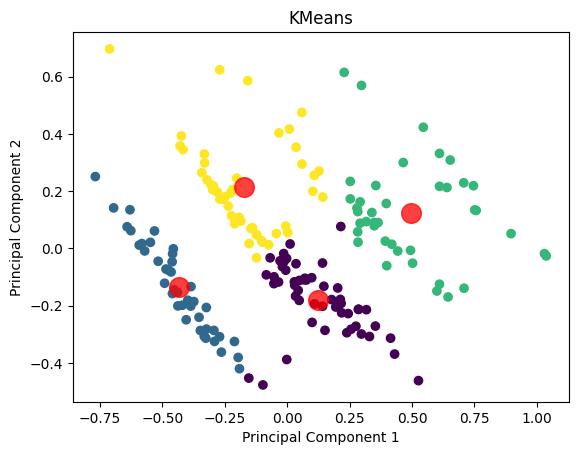

In [32]:

# 1.2 DOES NOT WORK// GOTTA FIX

from sklearn.cluster import KMeans
pca = X_pca.fit_transform(X)
KM = KMeans(n_clusters = 4, random_state = 0)
labels = KM.fit_predict(pca)

scatter = plt.scatter(pca[:,0], pca[:,1], c = labels, cmap = 'viridis')
plt.scatter(KM.cluster_centers_[:,0], KM.cluster_centers_[:,1], c = 'red', s = 200, alpha = 0.75)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans')
plt.show()

# PART 2 - EM

EM Algorithm finds clusters by treating each cluster as a 2D Gaussian distribution, and then fits the parameters of each distribution to accurately model the data. The goal is to find the optimal parameters for each of the Gaussians which model the data accurately.

Each cluster distribution is of the form $\pi_c \mathcal{N}(\mu_c, \sum_c)$, for each cluster $c, 0 \leq c < k$. For each cluster, we have the parameters $\mu_c, \pi_c$ and $\sum_c$.

$\pi_c$ denotes the cluster "strength" or "size" for each cluster. It represents the prior strength for a cluster, i.e. how likely it is that any point in the dataset belongs to that cluster.

$\mu_c$ denotes the cluster mean (a 2D point). The cluster distribution is centered around this point.

$\sum_c$ denotes the cluster covariance. Covariance is a generalization of variance $\sigma$ to multiple variables (in our case, 2D coordinates). It is a $2 \times 2$ matrix which represents the spread of each of the $x$ and $y$ coordinates.

The EM Algorithm has 2 steps, which are repeated till convergence:
- Expectation: We treat all of the cluster parameters as fixed. We then compute the probabilities of each point belonging to each cluster.
- Maximization: We treat the cluster probabilities as fixed and update the distribution parameters.

We start by initializing our EMModel class. This is the main class which will store our data and distribution parameters. We will also write all the functionality in it.

`X` is a matrix of size $N \times 2$

`k` is the number of clusters we want (4 in our case).

`max_iters` is the number of iterations we will run the algorithm for.

`self.dim` is the number of dimensions (2 in our case).

`self.N` is the number of points in the dataset (500 in our case).

`self.mu` stores all the cluster means. Size is $k \times 2$, as we have to store one point for each cluster.We initialize the cluster means by randomly picking k points from the dataset. 

`self.pi` stores all the cluster priors (strengths). Size is $k \times 1$, as it is just one number for each cluster. It is initialized to $\frac{1}{k}$ for each cluster.

`self.sigma` stores all the cluster covariance matrices. Size is $k \times 2 \times 2$, as we have to store a $2 \times 2$ matrix for each cluster. It is initialized to diagonal matrices with diagonal value $5.0$.

### Useful functions

To draw values from a multivariate normal distribution, use the `scipy.stats.multivariate_normal` function. For example, to draw values from a normal distribution with mean `mu` and covariance matrix `sigma`, you can use the following code:

`val = multivariate_normal(mean=mu, cov=sigma).pdf(X)` where `X` is an $N \times 2$ matrix.

**To-do:** (2.1)  (2 points)

Initialize `self.mu` , `self.pi`, and `self.sigma` according to the descriptions above.

In [2]:
class EMModel:
    
    def __init__(self, X, k, max_iters):
        """
        This function initializes our parameters (mu, pi and sigma) and plots our data points.
        """
        self.X = X
        self.k = k
        self.max_iters = max_iters
        
        self.dim = self.X.shape[1] # Equals 2, as we are considering 2D points
        self.N = self.X.shape[0] # Equals the number of points in the dataset
        
        """
        Here we initialize mu, pi and sigma. Mu is k X 2, Pi is k X 1, Sigma is k X 2 X 2
        """
        self.mu = ...  #YOUR CODE HERE
        self.pi =  ... # YOUR CODE HERE
        self.sigma = ... # YOUR CODE HERE
            
        """
        This part is required to plot clusters
        """
        x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        self.XY = np.array([x.flatten(),y.flatten()]).T
            
        """
        Finally, let's visualize our data points
        """
        self.plot_data('Initial State')

We define a function `plot_data` to plot our data as well as our clusters. This function plots our data points, and creates a contour plot for each cluster using its `mu` and `sigma` values.

In [3]:
from scipy.stats import multivariate_normal

def plot_data(self, title, colors=None):
    """
    This function creates a scatter plot of all the data points. It also creates a contour plot of the probability 
    distributions of each of the clusters (specified by mu, pi and sigma)
    """
    fig = plt.figure(figsize=(6,6))
    ax0 = fig.add_subplot(111)
    ax0.scatter(self.X[:,0], self.X[:,1], c=colors)
    ax0.set_title(title)
    for m,c in zip(self.mu,self.sigma):
        multi_normal = multivariate_normal(mean=m,cov=c)
        ax0.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
        ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
        
EMModel.plot_data = plot_data

Now we define our `expectation` function. This function's job is to compute $r_{ic}$, which is the probability that point $i$ belongs to cluster $c$ . ($0 \leq i < N$, $0 \leq c < k$)

We will store $r_{ic}$ as a matrix of size $N \times k$. (as we have to store the probability of every point for each cluster).

$r_{ic}$ is computed as follows:
<img src="ric.png">

To compute it, we basically:
- compute its probability under cluster model $c$
- normalize it to sum to 1 using its probabilities from all the clusters

Finally we should return `r` after computing it.

**To-do:** (2.2)  (10 points)

Complete the `expectation` method. (5 points)

In [ ]:
def expectation(self):
    # YOUR CODE HERE
    r = ...
    return r
    
EMModel.expectation = expectation

Now we define the "maximization" step in the `maximization` function. This function's job is to take the previously computed $r_{ic}$ and update the parameters $\mu_c, \sum_c$ of each cluster distribution. This is done as follows:
<img src="m2.png">


### Here, $N = \sum_{c} N_c$

Basically you should re-compute `mu`, `sigma` and `pi` using the previously computed `r` as per the given formulas.

**To-do:** (5 points)


Complete the `maximization` method.

In [ ]:
def maximization(self, r):
    # YOUR CODE HERE
    ...
    
EMModel.maximization = maximization



Now we write our main `run()` function which runs the EM Algorithm. This performs `max_iter` iterations of expectation and maximization.

**To-do:** (2.3)   (3 points)

Complete the `run` method. 

In [ ]:
def run(self):
    
    # YOUR CODE HERE
    ...

    color_labels = ... # YOUR CODE HERE
    self.plot_data('Final State', color_labels)
    
EMModel.run = run

Finally, we instantiate the `EMModel` class and run the algorithm on the PCA transformed 2 dimensional class data.

**To-do:** (2.4)  (1 point)

Run EM on the dataset. Your labeled cluster plot should look a lot better than the one from K-means. 

Use any parameters you think they are appropriate for our dataset. 


In [ ]:
#YOUR CODE HERE

### Part 3: Hierarchical Clustering

Hierarchical Clustering is another useful clustering algorithm. One unique feature of the hierarchical clustering is that it is able to generate within-cluster clusters. A super cluster can have multiple subclusters. Finding the subclusters can help us understand additional distributions on dataset with multiple features.

**To-do:**(3.1)  (2 points)

1. Use the hierarchy module from scipy (`scipy.cluser.hierarchy`) to produce a linkage matrix of the PCA transformed class dataset. 
Read the documentation on the linkage method. Make sure to choose a distance method that would produce a meaningful dendrogram.

Documentaton on the linkage method: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

2. Plot the dendrogram using the `dendrogram` method. 
Documentation on the dendrogram method: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html


In [ ]:
# YOUR CODE HERE

### STOP ! Have you run all the code blocks ? 
If not, please do so. All the requested code output should be visible. 

## Submission:
Please submit your notebook (.ipynb file) and an exported PDF copy (you can upload seperately without zipping the files) on GradeScope under the correct assignment with all of the cell outputs visible. It is normal to see Grapescope auto-grader outputs a score of 0.

If you are running on Datahub or the Anaconda Navigator and you are having trouble with exporting to PDF, you can use browser print page. If nothing works, you can submit without the PDF. Note, the .ipynb notebook file is required. 

